# Phase 4:  Convolutional Neural Networks For Detection Of Pneumonia in Chest X-Ray Images


* Jonah Devoy
* Contact Me: <a href="www.linkedin.com/in/jonahdevoy"> Linkedin URL  </a>

By setting a specific seed value, in this case, 42, you ensure that subsequent random number generation will produce the same sequence of numbers every time you run the code with the same seed. For example, if you have a program that involves random elements, such as generating random numbers or shuffling a dataset, setting a fixed seed allows you to obtain the same results consistently. This can be helpful when you need to compare or replicate experiments, or when you want to ensure consistent behavior across different runs of the code.

In [57]:
from tensorflow.random import set_seed
set_seed(42)

import numpy as np

np.random.seed(123)

In a nutshell, LIME is used to explain predictions of your machine learning model. The explanations should help you to understand why the model behaves the way it does. If the model isn't behaving as expected, there's a good chance you did something wrong in the data preparation phase.

In [58]:
# Import Statements
import os
import glob

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import models, layers, optimizers, regularizers, activations
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16, VGG19

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import class_weight

import lime
from lime import lime_base
from lime import lime_image
from skimage.segmentation import mark_boundaries

from keras.applications import ResNet50

# Data Preprocessing and Exploration
- Obtain and Store the Data in a train / test / val split
- Scale data
- Explore the data
- check for class imbalance
- look at images

In [59]:
# File Paths
train_pneumonia = '/Users/jdapeman/Documents/chest_xray/chest_xray/train/PNEUMONIA'
train_normal = '/Users/jdapeman/Documents/chest_xray/chest_xray/train/NORMAL'

test_pneumonia = '/Users/jdapeman/Documents/chest_xray/chest_xray/test/PNEUMONIA'
test_normal = '/Users/jdapeman/Documents/chest_xray/chest_xray/test/NORMAL'

val_pneumonia = '/Users/jdapeman/Documents/chest_xray/chest_xray/val/PNEUMONIA'
val_normal = '/Users/jdapeman/Documents/chest_xray/chest_xray/val/NORMAL'

# How many images in each set
print('Train Pneumonia', len(os.listdir(train_pneumonia)))
print('Train Normal', len(os.listdir(train_normal)))
print('Test Pneumonia', len(os.listdir(test_pneumonia)))
print('Test Normal', len(os.listdir(test_normal)))
print('Val Pneumonia', len(os.listdir(val_pneumonia)))
print('Val Normal', len(os.listdir(val_normal)))

Train Pneumonia 3876
Train Normal 1342
Test Pneumonia 390
Test Normal 234
Val Pneumonia 9
Val Normal 9


In [60]:
# Create data generators for each the train, test, and val. Use a target size of 224x224 px for each image
# at first the batch sizes were too small, at higher values while still being a value of the power of two, 
# I obtained better results

train_g = ImageDataGenerator(rescale=1./255).flow_from_directory(
                                                    '/Users/jdapeman/Documents/chest_xray/chest_xray/train',
                                                     target_size=(224, 224),
                                                     batch_size=32,
                                                     class_mode='binary',
                                                     seed=42)
test_g = ImageDataGenerator(rescale=1./255).flow_from_directory(
                                                    '/Users/jdapeman/Documents/chest_xray/chest_xray/test',
                                                     target_size=(224, 224),
                                                     batch_size=32,
                                                     class_mode='binary',
                                                     seed=42)
val_g = ImageDataGenerator(rescale=1./255).flow_from_directory(
                                                    '/Users/jdapeman/Documents/chest_xray/chest_xray/val',
                                                     target_size=(224, 224),
                                                     batch_size=32,
                                                     class_mode='binary',
                                                     seed=42)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [61]:
# Create the data sets with the train/test/val splits
X_train, y_train = next(train_g)
X_test, y_test = next(test_g)
X_val, y_val = next(val_g)

In [64]:
# Check shapes of the image data
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(32, 224, 224, 3)
(32, 224, 224, 3)
(16, 224, 224, 3)


In [65]:
# ploting normal and pneumonia images side by side 
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(np.squeeze(X_train[0]), cmap='gray')
ax[0].axis('off')
ax[0].set_title('Normal X-Ray')

ax[1].imshow(np.squeeze(X_train[1]), cmap='gray')
ax[1].axis('off')
ax[1].set_title('Pneumonia X-Ray')

plt.tight_layout()
plt.show()

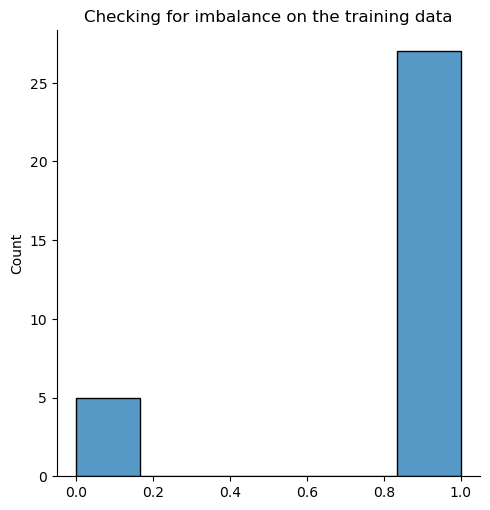

In [66]:
# Look at class imbalance of training data
sns.displot(y_train)
plt.title('Checking for imbalance on the training data')
plt.show()

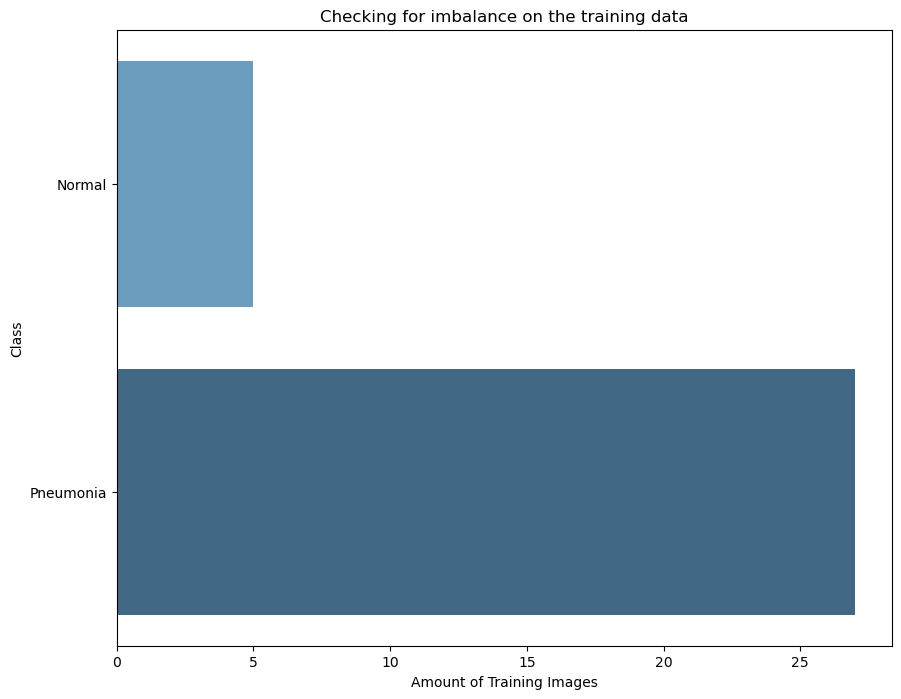

In [67]:
plt.figure(figsize=(10,8))
sns.barplot(x=[sum(y_train==0), sum(y_train==1)],
            y=['Normal', 'Pneumonia'],
            palette='Blues_d')
plt.title('Checking for imbalance on the training data')
plt.ylabel('Class')
plt.xlabel('Amount of Training Images')
plt.show()

# Baseline CNN

In [68]:
#  Baseline model with 3 convolutional layers, 3 max pooling layers, and one fully connected layer
model_1 = models.Sequential()

model_1.add(Conv2D(32, (3, 3), activation='relu',
                    input_shape=(224, 224, 3)))

model_1.add(MaxPooling2D((2, 2)))
model_1.add(Conv2D(32, (3, 3), activation='relu'))
model_1.add(MaxPooling2D(2, 2))

model_1.add(Conv2D(64, (3, 3), activation='relu'))
model_1.add(MaxPooling2D((2, 2)))

model_1.add(Flatten())
model_1.add(Dense(64, activation='relu'))
model_1.add(Dense(1, activation='sigmoid'))

model_1.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['acc'])

In [69]:
# Taking a look at the summary of all layers, helpful for understanding the 
# architecture of the model and verifying that it matches your expectations
model_1.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 111, 111, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_37 (Conv2D)          (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 54, 54, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_38 (Conv2D)          (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 26, 26, 64)       

In [70]:
history = model_1.fit(X_train,
                       y_train,
                       epochs=20,
                       batch_size=32,
                       validation_data=(X_val, y_val))

Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 0.6830 - acc: 0.8438 - val_loss: 2.3188 - val_acc: 0.5000
Epoch 2/20
1/1 [==============================] - 1s 610ms/step - loss: 0.7467 - acc: 0.8438 - val_loss: 1.3117 - val_acc: 0.5000
Epoch 3/20
1/1 [==============================] - 1s 641ms/step - loss: 0.4731 - acc: 0.8438 - val_loss: 0.7549 - val_acc: 0.5000
Epoch 4/20
1/1 [==============================] - 1s 617ms/step - loss: 0.4984 - acc: 0.8438 - val_loss: 0.7718 - val_acc: 0.5000
Epoch 5/20
1/1 [==============================] - 1s 596ms/step - loss: 0.4734 - acc: 0.8438 - val_loss: 0.9820 - val_acc: 0.5000
Epoch 6/20
1/1 [==============================] - 1s 595ms/step - loss: 0.4087 - acc: 0.8438 - val_loss: 1.3686 - val_acc: 0.5000
Epoch 7/20
1/1 [==============================] - 1s 593ms/step - loss: 0.4302 - acc: 0.8438 - val_loss: 1.2556 - val_acc: 0.5000
Epoch 8/20
1/1 [==============================] - 1s 604ms/step - loss: 0.3900 - acc: 0.8438 

In [71]:
def test_result(results, y_test=y_test):
  """
  input results of model fitting.
  output loss and accuracy curves, and confusion matrix
  """

  history = results.history
  plt.figure()
  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.legend(['loss', 'val_loss'])
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.show()

  plt.figure()
  plt.plot(history['acc'])
  plt.plot(history['val_acc'])
  plt.legend(['acc', 'val_acc'])
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.show()

  y_hat_test = results.model.predict(X_test)
  thresh = 0.5
  y_pred = (y_hat_test < thresh).astype(int)
  y_true = y_test.astype(int)
  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(cm, annot=True, cmap='Blues', fmt='0.5g')
  plt.xlabel('Predictions')
  plt.ylabel('Actuals')
  plt.title('Model Confusion Matrix')
  plt.show()

  print(classification_report(y_true, y_pred))
  print('\n')

  test_loss, test_acc = results.model.evaluate(X_test, y_test)
  print(f'Test Loss: {test_loss}')
  print(f'Test Acc: {test_acc}')

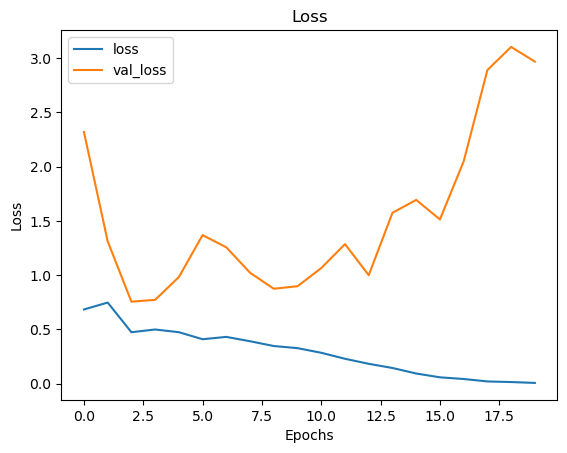

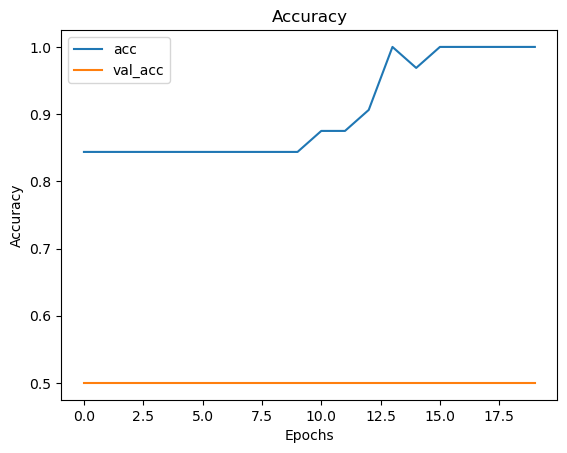

1/1 [==============================] - 0s 198ms/step


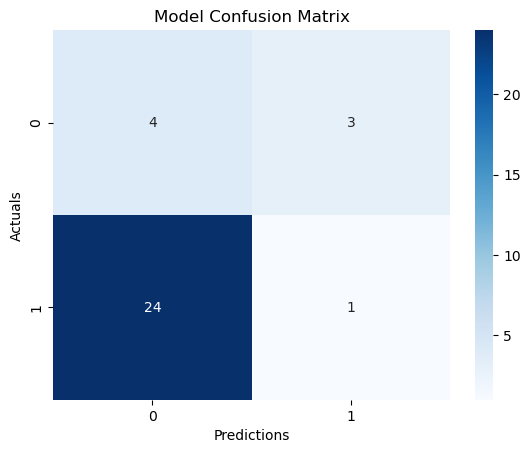

              precision    recall  f1-score   support

           0       0.14      0.57      0.23         7
           1       0.25      0.04      0.07        25

    accuracy                           0.16        32
   macro avg       0.20      0.31      0.15        32
weighted avg       0.23      0.16      0.10        32



1/1 [==============================] - 0s 162ms/step - loss: 0.6302 - acc: 0.8438
Test Loss: 0.6302412748336792
Test Acc: 0.84375


In [72]:
test_result(history)

# Evaluation

- The model predominantly predicts the absence of pneumonia, which could be attributed to class imbalance. Furthermore, the issue could be exacerbated by the small size of the validation set.

# Iteration 2
- Alleviate the class imbalance by assigning suitable class weights, taking into account the imbalanced predictions of the baseline model as shown in its confusion matrix.
- Investigate the possibility of training the model for more epochs while incorporating early stopping to mitigate the risk of overfitting.

In [73]:
# Set up out class weights
weights = compute_class_weight(class_weight ='balanced', classes =np.unique(y_train),y= y_train)
weights_1 = dict(zip(np.unique(y_train), weights))
weights_1

{0.0: 3.2, 1.0: 0.5925925925925926}

In [74]:
# Set up early stopping and learning rate reduction
stop_early = EarlyStopping(monitor='val_loss', mode='min', patience=5)
redox_lr_1 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
callback_1 = [stop_early, redox_lr_1]

In [75]:
# Build model iteration 2 with improvements above and another conv layer
model_2 = models.Sequential()

model_2.add(Conv2D(32, (3, 3), activation='relu',
                    input_shape=(224, 224, 3)))
model_2.add(MaxPooling2D((2, 2)))

model_2.add(Conv2D(32, (3, 3), activation='relu'))
model_2.add(MaxPooling2D(2, 2))

model_2.add(Conv2D(64, (3, 3), activation='relu'))
model_2.add(MaxPooling2D((2, 2)))

model_2.add(Flatten())
model_2.add(Dense(64, activation='relu'))
model_2.add(Dense(1, activation='sigmoid'))

model_2.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['acc'])

In [76]:
model_2.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 111, 111, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_40 (Conv2D)          (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 54, 54, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_41 (Conv2D)          (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_29 (MaxPooli  (None, 26, 26, 64)      

In [77]:
results = model_2.fit(X_train,
                   y_train,
                   epochs=50,
                   batch_size=32,
                   validation_data=(X_val, y_val),
                   class_weight=weights_1,
                   callbacks=callback_1)

Epoch 1/50
1/1 [==============================] - 1s 1s/step - loss: 0.6978 - acc: 0.5938 - val_loss: 0.8429 - val_acc: 0.5000 - lr: 0.0010
Epoch 2/50
1/1 [==============================] - 1s 642ms/step - loss: 0.8007 - acc: 0.1562 - val_loss: 0.8937 - val_acc: 0.5000 - lr: 0.0010
Epoch 3/50
1/1 [==============================] - 1s 645ms/step - loss: 0.8625 - acc: 0.8438 - val_loss: 0.7161 - val_acc: 0.5000 - lr: 0.0010
Epoch 4/50
1/1 [==============================] - 1s 605ms/step - loss: 0.6383 - acc: 0.8438 - val_loss: 0.6602 - val_acc: 0.6250 - lr: 0.0010
Epoch 5/50
1/1 [==============================] - 1s 605ms/step - loss: 0.5776 - acc: 0.5000 - val_loss: 0.6625 - val_acc: 0.5625 - lr: 0.0010
Epoch 6/50
1/1 [==============================] - 1s 610ms/step - loss: 0.5672 - acc: 0.2500 - val_loss: 0.6420 - val_acc: 0.6875 - lr: 0.0010
Epoch 7/50
1/1 [==============================] - 1s 593ms/step - loss: 0.4973 - acc: 0.7500 - val_loss: 0.6944 - val_acc: 0.5625 - lr: 0.0010
Ep

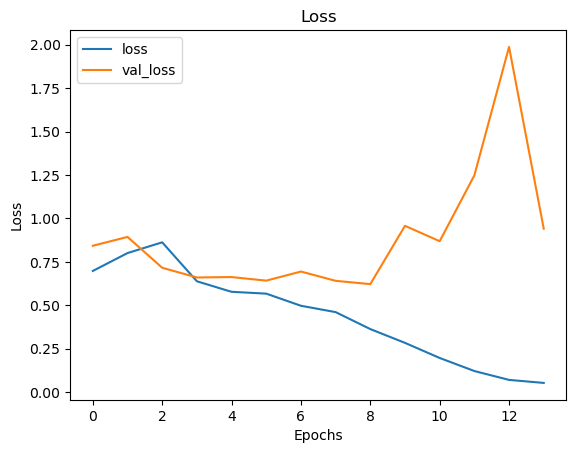

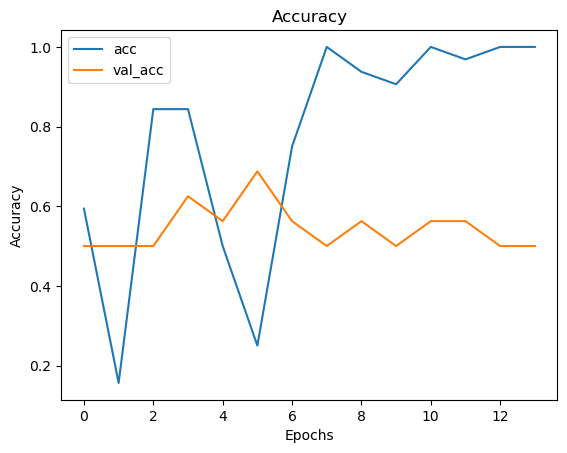

1/1 [==============================] - 0s 183ms/step


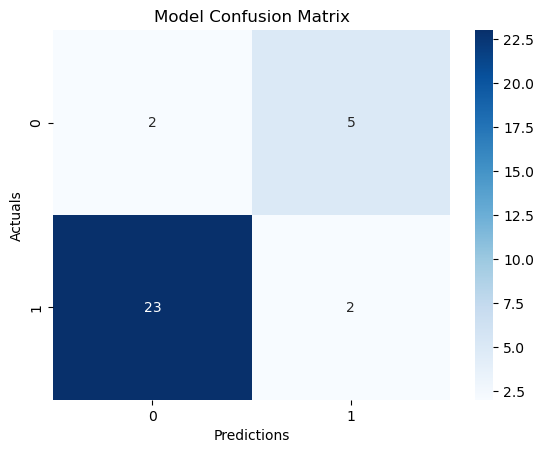

              precision    recall  f1-score   support

           0       0.08      0.29      0.12         7
           1       0.29      0.08      0.12        25

    accuracy                           0.12        32
   macro avg       0.18      0.18      0.12        32
weighted avg       0.24      0.12      0.12        32



1/1 [==============================] - 0s 159ms/step - loss: 0.3988 - acc: 0.8750
Test Loss: 0.39875921607017517
Test Acc: 0.875


In [78]:
test_result(results)

# Evaluation

There is minimal progress observed in this case. Although the loss decreased, the accuracy remains somewhat unchanged.

It is evident that the validation curves are not converging smoothly, which I suspect is a result of their limited size. In this scenario, the validation set consists of only 16 images, whereas the training set comprises over 5000 images. Consequently, in the next iteration, I intend to modify the validation training split within the model fitting parameters instead of relying on the small provided validation set.

# Iteration 3
- Based on the second iteration, I will attempt to modify the size of the validation set and observe if it leads to any enhancements in the loss and accuracy curves.

In [79]:
model_3 = models.Sequential()

model_3.add(Conv2D(32, (3, 3), activation='relu',
                    input_shape=(224, 224, 3)))
model_3.add(MaxPooling2D((2, 2)))

model_3.add(Conv2D(32, (3, 3), activation='relu'))
model_3.add(MaxPooling2D(2, 2))

model_3.add(Conv2D(64, (3, 3), activation='relu'))
model_3.add(MaxPooling2D((2, 2)))

model_3.add(Flatten())
model_3.add(Dense(64, activation='relu'))
model_3.add(Dense(1, activation='sigmoid'))

model_3.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['acc'])

In [80]:
results = model_3.fit(X_train,
                   y_train,
                   epochs=50,
                   batch_size=32,
                   validation_split=.2,
                   class_weight=weights_1,
                   callbacks=callback_1)

Epoch 1/50
1/1 [==============================] - 1s 1s/step - loss: 0.6252 - acc: 0.4800 - val_loss: 1.0408 - val_acc: 0.7143 - lr: 0.0010
Epoch 2/50
1/1 [==============================] - 0s 491ms/step - loss: 1.3299 - acc: 0.8800 - val_loss: 0.8123 - val_acc: 0.2857 - lr: 0.0010
Epoch 3/50
1/1 [==============================] - 0s 491ms/step - loss: 0.6518 - acc: 0.1200 - val_loss: 0.9496 - val_acc: 0.2857 - lr: 0.0010
Epoch 4/50
1/1 [==============================] - 0s 489ms/step - loss: 0.7565 - acc: 0.1200 - val_loss: 0.6275 - val_acc: 0.7143 - lr: 0.0010
Epoch 5/50
1/1 [==============================] - 0s 489ms/step - loss: 0.5273 - acc: 0.8000 - val_loss: 0.5737 - val_acc: 0.7143 - lr: 0.0010
Epoch 6/50
1/1 [==============================] - 0s 483ms/step - loss: 0.5718 - acc: 0.8800 - val_loss: 0.5509 - val_acc: 0.7143 - lr: 0.0010
Epoch 7/50
1/1 [==============================] - 0s 499ms/step - loss: 0.5048 - acc: 0.8800 - val_loss: 0.5612 - val_acc: 0.8571 - lr: 0.0010
Ep

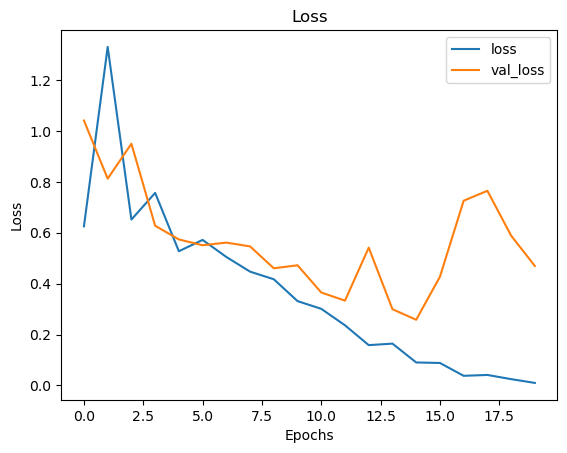

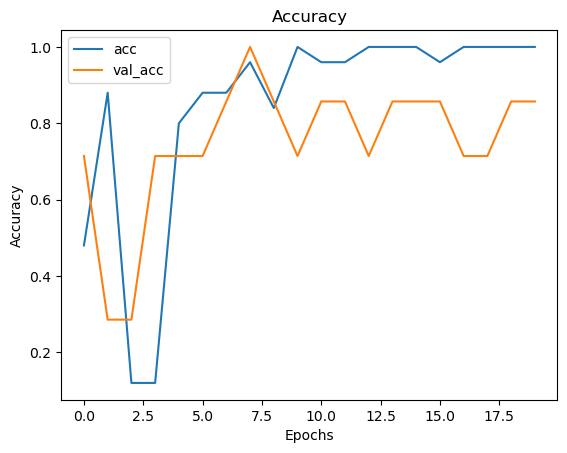

1/1 [==============================] - 0s 201ms/step


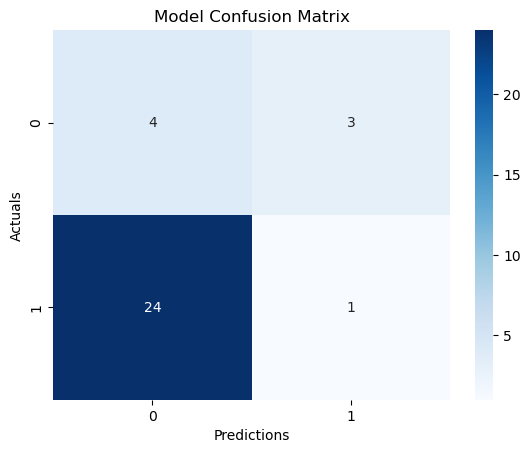

              precision    recall  f1-score   support

           0       0.14      0.57      0.23         7
           1       0.25      0.04      0.07        25

    accuracy                           0.16        32
   macro avg       0.20      0.31      0.15        32
weighted avg       0.23      0.16      0.10        32



1/1 [==============================] - 0s 161ms/step - loss: 0.4940 - acc: 0.8438
Test Loss: 0.49398690462112427
Test Acc: 0.84375


In [81]:
test_result(results)

Incorporate a similar approach as in iteration 2, but with the inclusion of 2 convolutional layers per block. Additionally, explore the utilization of a different optimizer, specifically 'RMSprop'.

In [82]:
model_3a = models.Sequential()

model_3a.add(Conv2D(32, (3, 3), activation='relu',
                    input_shape=(224, 224, 3)))
model_3a.add(Conv2D(32, (3, 3), activation='relu'))
model_3a.add(MaxPooling2D((2, 2)))

model_3a.add(Conv2D(32, (3, 3), activation='relu'))
model_3a.add(Conv2D(32, (3, 3), activation='relu'))
model_3a.add(MaxPooling2D(2, 2))

model_3a.add(Conv2D(64, (3, 3), activation='relu'))
model_3a.add(Conv2D(64, (3, 3), activation='relu'))
model_3a.add(MaxPooling2D((2, 2)))

model_3a.add(Flatten())
model_3a.add(Dense(64, activation='relu'))
model_3a.add(Dense(1, activation='sigmoid'))

model_3a.compile(loss='binary_crossentropy',
                optimizer='RMSprop',
                metrics=['acc'])

In [83]:
results = model_3a.fit(X_train,
                   y_train,
                   epochs=50,
                   batch_size=32,
                   validation_split=.2,
                   class_weight=weights_1,
                   callbacks=[stop_early])

Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 0.6266 - acc: 0.8800 - val_loss: 0.5935 - val_acc: 0.7143
Epoch 2/50
1/1 [==============================] - 1s 1s/step - loss: 0.6355 - acc: 0.8800 - val_loss: 0.7139 - val_acc: 0.2857
Epoch 3/50
1/1 [==============================] - 1s 1s/step - loss: 0.6335 - acc: 0.1200 - val_loss: 0.7001 - val_acc: 0.2857
Epoch 4/50
1/1 [==============================] - 1s 1s/step - loss: 0.6292 - acc: 0.1200 - val_loss: 0.6892 - val_acc: 0.7143
Epoch 5/50
1/1 [==============================] - 1s 1s/step - loss: 0.6261 - acc: 0.8800 - val_loss: 0.6737 - val_acc: 0.7143
Epoch 6/50
1/1 [==============================] - 1s 1s/step - loss: 0.6221 - acc: 0.8800 - val_loss: 0.6373 - val_acc: 0.7143


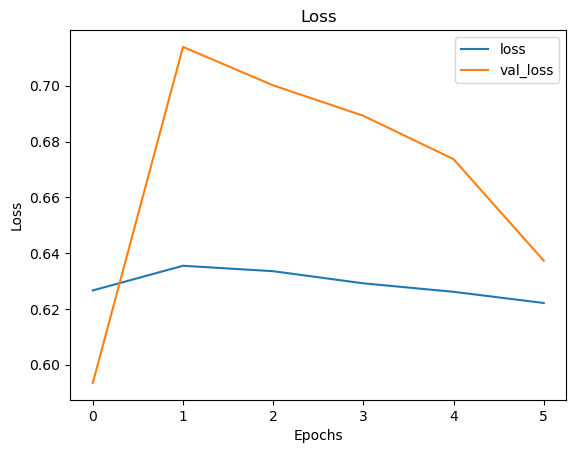

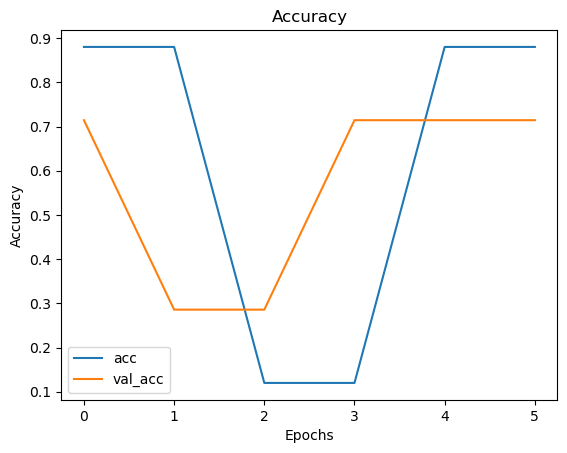

1/1 [==============================] - 0s 390ms/step


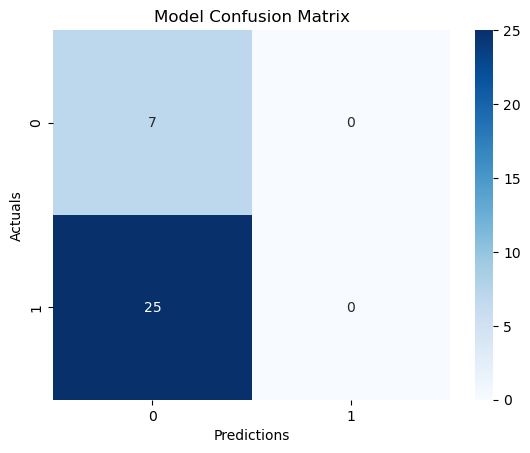

              precision    recall  f1-score   support

           0       0.22      1.00      0.36         7
           1       0.00      0.00      0.00        25

    accuracy                           0.22        32
   macro avg       0.11      0.50      0.18        32
weighted avg       0.05      0.22      0.08        32





/Users/jdapeman/anaconda3/envs/apple/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jdapeman/anaconda3/envs/apple/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jdapeman/anaconda3/envs/apple/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

1/1 [==============================] - 0s 366ms/step - loss: 0.6112 - acc: 0.7812
Test Loss: 0.6112170815467834
Test Acc: 0.78125


In [84]:
test_result(results)

# Evaluation

- Although there was not a significant improvement in the test set, the visual representation of these curves shows a considerable enhancement. Model 3a demonstrated some improvement in this regard. Consequently, in subsequent iterations, I will retain this validation split rather than relying on the small provided validation set.

# Iteration 4
- In this iteration, my objective is to explore a more intricate architecture for the model. I plan to achieve this by incorporating 2 convolutional layers for each max pooling layer. While researching successful image classification approaches with X-rays, this approach appeared to be widely adopted. Given that the previous models predominantly predicted non-pneumonia cases, I believe that including more convolutional layers will enhance the model's ability to detect subtle details and nuances in pneumonia images. Additionally, I will introduce two additional blocks of layers, effectively deepening the model. Throughout this process, I will continue utilizing 'RMSprop' as the optimizer.

In [85]:
model_4 = models.Sequential()

model_4.add(Conv2D(32, (3, 3), activation='relu',
                    input_shape=(224, 224, 3)))
model_4.add(Conv2D(32, (3, 3), activation='relu'))
model_4.add(MaxPooling2D((2, 2)))

model_4.add(Conv2D(32, (3, 3), activation='relu'))
model_4.add(Conv2D(32, (3, 3), activation='relu'))
model_4.add(MaxPooling2D(2, 2))

model_4.add(Conv2D(64, (3, 3), activation='relu'))
model_4.add(Conv2D(64, (3, 3), activation='relu'))
model_4.add(MaxPooling2D((2, 2)))

model_4.add(Conv2D(64, (3, 3), activation='relu'))
model_4.add(Conv2D(64, (3, 3), activation='relu'))
model_4.add(MaxPooling2D((2, 2)))

model_4.add(Flatten())
model_4.add(Dense(128, activation='relu'))
model_4.add(Dense(64, activation='relu'))
mod4.add(Dense(1, activation='sigmoid'))

model_4.compile(loss='binary_crossentropy',
                optimizer='RMSprop',
                metrics=['acc'])

In [86]:
model_4.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_51 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 conv2d_52 (Conv2D)          (None, 220, 220, 32)      9248      
                                                                 
 max_pooling2d_36 (MaxPooli  (None, 110, 110, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_53 (Conv2D)          (None, 108, 108, 32)      9248      
                                                                 
 conv2d_54 (Conv2D)          (None, 106, 106, 32)      9248      
                                                                 
 max_pooling2d_37 (MaxPooli  (None, 53, 53, 32)        0         
 ng2D)                                               

In [87]:
results = model_4.fit(X_train,
                   y_train,
                   epochs=50,
                   batch_size=32,
                   validation_split=.2,
                   class_weight=weights_1,
                   callbacks=[stop_early])

Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 0.6278 - acc: 0.1200 - val_loss: 0.6868 - val_acc: 0.7143
Epoch 2/50
1/1 [==============================] - 1s 1s/step - loss: 0.6259 - acc: 0.8800 - val_loss: 0.6678 - val_acc: 0.7143
Epoch 3/50
1/1 [==============================] - 1s 1s/step - loss: 0.6211 - acc: 0.8800 - val_loss: 0.6115 - val_acc: 0.7143
Epoch 4/50
1/1 [==============================] - 1s 1s/step - loss: 0.6263 - acc: 0.8800 - val_loss: 0.6943 - val_acc: 0.2857
Epoch 5/50
1/1 [==============================] - 1s 1s/step - loss: 0.6278 - acc: 0.1200 - val_loss: 0.6864 - val_acc: 0.7143
Epoch 6/50
1/1 [==============================] - 1s 1s/step - loss: 0.6254 - acc: 0.8800 - val_loss: 0.6815 - val_acc: 0.7143
Epoch 7/50
1/1 [==============================] - 1s 1s/step - loss: 0.6240 - acc: 0.8800 - val_loss: 0.6772 - val_acc: 0.7143
Epoch 8/50
1/1 [==============================] - 1s 1s/step - loss: 0.6228 - acc: 0.8800 - val_loss: 0.6733 - 

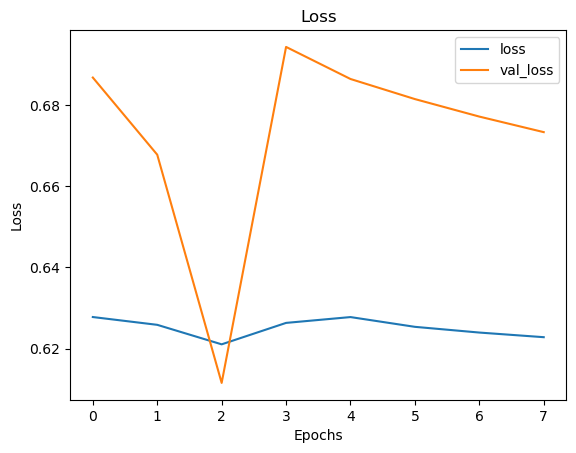

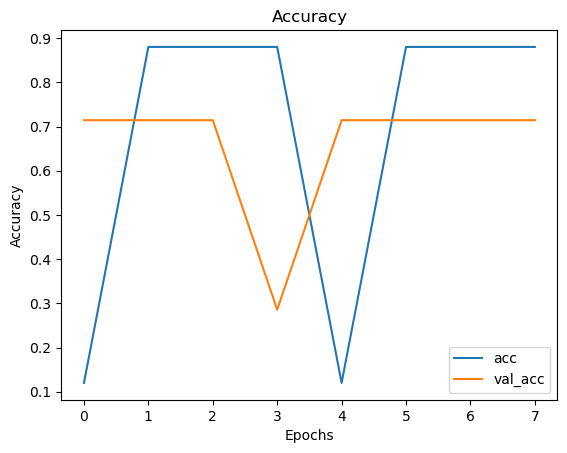

1/1 [==============================] - 0s 413ms/step


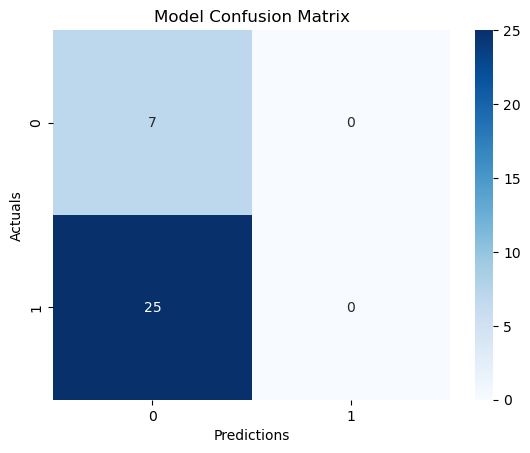

              precision    recall  f1-score   support

           0       0.22      1.00      0.36         7
           1       0.00      0.00      0.00        25

    accuracy                           0.22        32
   macro avg       0.11      0.50      0.18        32
weighted avg       0.05      0.22      0.08        32





/Users/jdapeman/anaconda3/envs/apple/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jdapeman/anaconda3/envs/apple/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jdapeman/anaconda3/envs/apple/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

1/1 [==============================] - 0s 385ms/step - loss: 0.6668 - acc: 0.7812
Test Loss: 0.6668102741241455
Test Acc: 0.78125


In [88]:
test_result(results)

# Evaluation

- The model has shown some improvement as a result of these modifications. When examining the classification report and the confusion matrix, it becomes evident that the model performs better in predicting normal X-rays. Only a small number of test images depicting normal cases were misclassified as pneumonia (False Positives). However, the model still struggles with correctly identifying pneumonia images, as there are numerous instances of False Negatives (pneumonia images misclassified as normal). In order to address this issue, I will continue iterating on this model to further enhance its accuracy.

# Iteration 5
- In this iteration, my goal is to increase the depth of the neural network by adding more layers. The intention is to extract additional features from the images in order to enhance the model's performance.

In [89]:
model_5 = models.Sequential()

model_5.add(Conv2D(32, (3, 3), activation='relu',
                    input_shape=(224, 224, 3)))
model_5.add(Conv2D(32, (3, 3), activation='relu'))
model_5.add(MaxPooling2D((2, 2)))

model_5.add(Conv2D(32, (3, 3), activation='relu'))
model_5.add(Conv2D(32, (3, 3), activation='relu'))
model_5.add(MaxPooling2D(2, 2))

model_5.add(Conv2D(64, (3, 3), activation='relu'))
model_5.add(Conv2D(64, (3, 3), activation='relu'))
model_5.add(MaxPooling2D((2, 2)))

model_5.add(Conv2D(64, (3, 3), activation='relu'))
model_5.add(Conv2D(64, (3, 3), activation='relu'))
model_5.add(MaxPooling2D((2, 2)))

model_5.add(Conv2D(128, (3, 3), activation='relu'))
model_5.add(Conv2D(128, (3, 3), activation='relu'))
model_5.add(MaxPooling2D((2, 2)))

model_5.add(Flatten())
model_5.add(Dense(128, activation='relu'))
model_5.add(Dense(64, activation='relu'))
model_5.add(Dense(1, activation='sigmoid'))

model_5.compile(loss='binary_crossentropy',
                optimizer='RMSprop',
                metrics=['acc'])

In [90]:
results = model_5.fit(X_train,
                   y_train,
                   epochs=50,
                   batch_size=32,
                   validation_split=.2,
                   class_weight=weights_1,
                   callbacks=[stop_early])

Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 0.6274 - acc: 0.8800 - val_loss: 0.6748 - val_acc: 0.7143
Epoch 2/50
1/1 [==============================] - 1s 1s/step - loss: 0.6227 - acc: 0.8800 - val_loss: 0.6238 - val_acc: 0.7143
Epoch 3/50
1/1 [==============================] - 1s 1s/step - loss: 0.6192 - acc: 0.8800 - val_loss: 0.6861 - val_acc: 0.7143
Epoch 4/50
1/1 [==============================] - 1s 1s/step - loss: 0.6255 - acc: 0.8800 - val_loss: 0.6734 - val_acc: 0.7143
Epoch 5/50
1/1 [==============================] - 1s 1s/step - loss: 0.6220 - acc: 0.8800 - val_loss: 0.6458 - val_acc: 0.7143
Epoch 6/50
1/1 [==============================] - 1s 1s/step - loss: 0.6170 - acc: 0.8800 - val_loss: 0.6273 - val_acc: 0.7143
Epoch 7/50
1/1 [==============================] - 1s 1s/step - loss: 0.6151 - acc: 0.8800 - val_loss: 0.6869 - val_acc: 0.7143


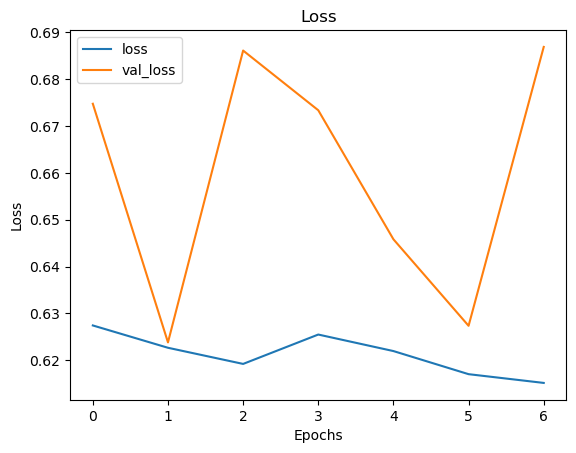

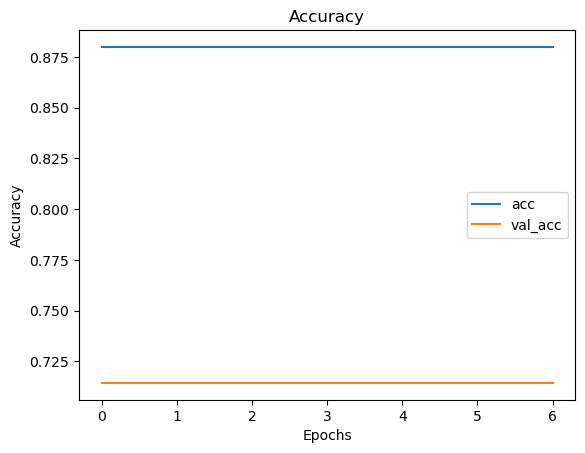

1/1 [==============================] - 0s 439ms/step


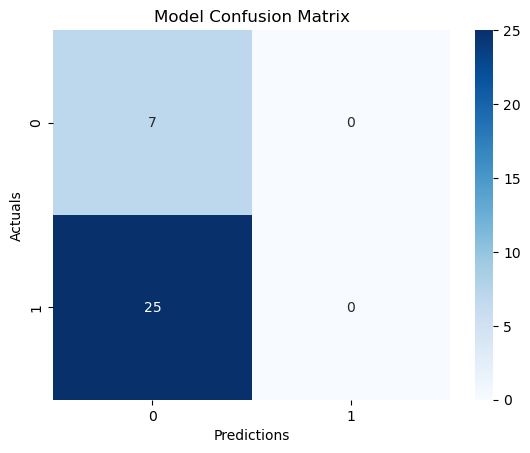

              precision    recall  f1-score   support

           0       0.22      1.00      0.36         7
           1       0.00      0.00      0.00        25

    accuracy                           0.22        32
   macro avg       0.11      0.50      0.18        32
weighted avg       0.05      0.22      0.08        32





/Users/jdapeman/anaconda3/envs/apple/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jdapeman/anaconda3/envs/apple/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jdapeman/anaconda3/envs/apple/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

1/1 [==============================] - 0s 392ms/step - loss: 0.6852 - acc: 0.7812
Test Loss: 0.6852128505706787
Test Acc: 0.78125


In [91]:
test_result(results)

# Evaluation

- The accuracy is not really improving here. 

# Iteration 6 and 7: Using Transfer Learning
- The disadvantage of using deep learning is that sometime you don't have a big enough training set to make a very robust model. However, keras allows us to use models that have been pre-trained on millions of images as a base layer
- In this iteration I will use the VGG19 model as my base and add my own layers on top to see if this improves my model's performance
- I will try 2 different methods

In [92]:
# Load our VGG19 model as our base
cnn_base = VGG19(weights='imagenet', 
                 include_top=False, 
                 input_shape=(224, 224, 3))

In [93]:
model_6 = models.Sequential()
model_6.add(cnn_base)
model_6.add(Flatten())
model_6.add(Dense(128, activation='relu'))
model_6.add(Dense(1, activation='sigmoid'))

In [94]:
cnn_base.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [95]:
# Check which layers can be frozen
for layer in model_6.layers:
  print("Layer name:", layer.name)
  print("Is trainable:", layer.trainable)

print("Total number of trainable weights:", len(model_6.trainable_weights))

vgg19 True
flatten_15 True
dense_34 True
dense_35 True
36


In [96]:
# Freeze the model
cnn_base.trainable = False

In [97]:
# Double check that it has been frozen
for layer in model_6.layers:
  print("Layer name:", layer.name)
  print("Is trainable:", layer.trainable)

print("Total number of trainable weights:", len(model_6.trainable_weights))

vgg19 False
flatten_15 True
dense_34 True
dense_35 True
4


In [98]:
model_6.compile(loss='binary_crossentropy',
                optimizer='RMSprop',
                metrics=['acc'])

In [99]:
model_6.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_15 (Flatten)        (None, 25088)             0         
                                                                 
 dense_34 (Dense)            (None, 128)               3211392   
                                                                 
 dense_35 (Dense)            (None, 1)                 129       
                                                                 
Total params: 23235905 (88.64 MB)
Trainable params: 3211521 (12.25 MB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [100]:
results = model_6.fit(X_train,
                   y_train,
                   epochs=50,
                   batch_size=32,
                   validation_split=.2,
                   class_weight=weights_1,
                   callbacks=[stop_early])

Epoch 1/50
1/1 [==============================] - 5s 5s/step - loss: 0.6356 - acc: 0.3200 - val_loss: 11.8361 - val_acc: 0.7143
Epoch 2/50
1/1 [==============================] - 4s 4s/step - loss: 14.3485 - acc: 0.8800 - val_loss: 7.2421 - val_acc: 0.2857
Epoch 3/50
1/1 [==============================] - 5s 5s/step - loss: 4.3325 - acc: 0.1200 - val_loss: 2.7672 - val_acc: 0.7143
Epoch 4/50
1/1 [==============================] - 5s 5s/step - loss: 1.9470 - acc: 0.8800 - val_loss: 2.1455 - val_acc: 0.2857
Epoch 5/50
1/1 [==============================] - 5s 5s/step - loss: 0.8204 - acc: 0.6000 - val_loss: 1.0031 - val_acc: 0.7143
Epoch 6/50
1/1 [==============================] - 5s 5s/step - loss: 0.1127 - acc: 1.0000 - val_loss: 0.1588 - val_acc: 0.8571
Epoch 7/50
1/1 [==============================] - 5s 5s/step - loss: 0.0134 - acc: 1.0000 - val_loss: 0.2279 - val_acc: 0.8571
Epoch 8/50
1/1 [==============================] - 5s 5s/step - loss: 0.0075 - acc: 1.0000 - val_loss: 0.2613 

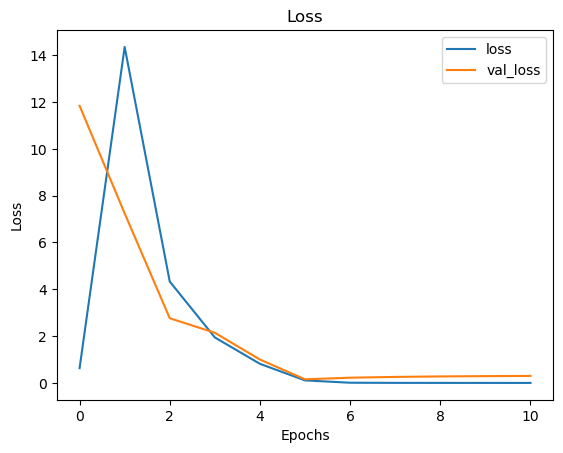

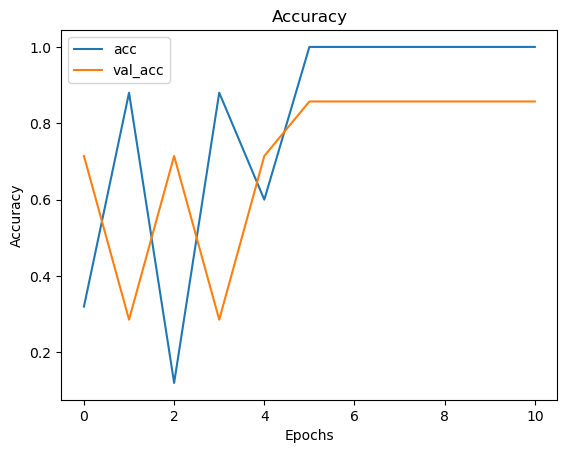

1/1 [==============================] - 4s 4s/step


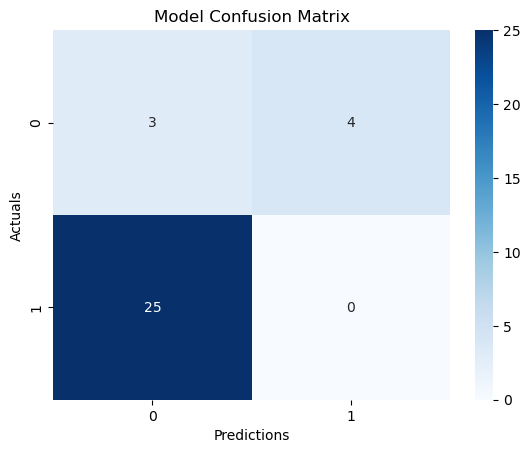

              precision    recall  f1-score   support

           0       0.11      0.43      0.17         7
           1       0.00      0.00      0.00        25

    accuracy                           0.09        32
   macro avg       0.05      0.21      0.09        32
weighted avg       0.02      0.09      0.04        32



1/1 [==============================] - 4s 4s/step - loss: 0.5763 - acc: 0.9062
Test Loss: 0.5762522220611572
Test Acc: 0.90625


In [101]:
test_result(results)

- Try another method
- include_top = True

In [102]:
model_7 = models.Sequential()
cnn_base2 = VGG19(weights='imagenet', include_top = True)
cnn_base2.trainable = False
model_7.add(cnn_base2)
model_7.add(Flatten())
model_7.add(Dense(64, activation='relu'))
model_7.add(Dense(1, activation='sigmoid'))
model_7.compile(optimizer='RMSprop',
             loss='binary_crossentropy',
             metrics=['acc'])

In [103]:
cnn_base2.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [104]:
results = model_7.fit(X_train,
                   y_train,
                   epochs=50,
                   batch_size=32,
                   validation_split=.2,
                   class_weight=weights_1,
                   callbacks=[stop_early])

Epoch 1/50
1/1 [==============================] - 5s 5s/step - loss: 0.6280 - acc: 0.1200 - val_loss: 0.6903 - val_acc: 0.7143
Epoch 2/50
1/1 [==============================] - 5s 5s/step - loss: 0.6266 - acc: 0.8800 - val_loss: 0.6873 - val_acc: 0.7143
Epoch 3/50
1/1 [==============================] - 5s 5s/step - loss: 0.6257 - acc: 0.8800 - val_loss: 0.6847 - val_acc: 0.7143
Epoch 4/50
1/1 [==============================] - 5s 5s/step - loss: 0.6249 - acc: 0.8800 - val_loss: 0.6826 - val_acc: 0.7143
Epoch 5/50
1/1 [==============================] - 5s 5s/step - loss: 0.6243 - acc: 0.8800 - val_loss: 0.6807 - val_acc: 0.7143
Epoch 6/50
1/1 [==============================] - 5s 5s/step - loss: 0.6238 - acc: 0.8800 - val_loss: 0.6790 - val_acc: 0.7143
Epoch 7/50
1/1 [==============================] - 5s 5s/step - loss: 0.6233 - acc: 0.8800 - val_loss: 0.6777 - val_acc: 0.7143
Epoch 8/50
1/1 [==============================] - 5s 5s/step - loss: 0.6230 - acc: 0.8800 - val_loss: 0.6762 - 

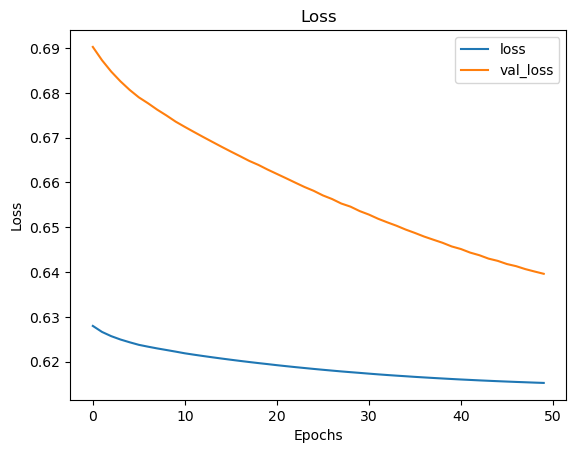

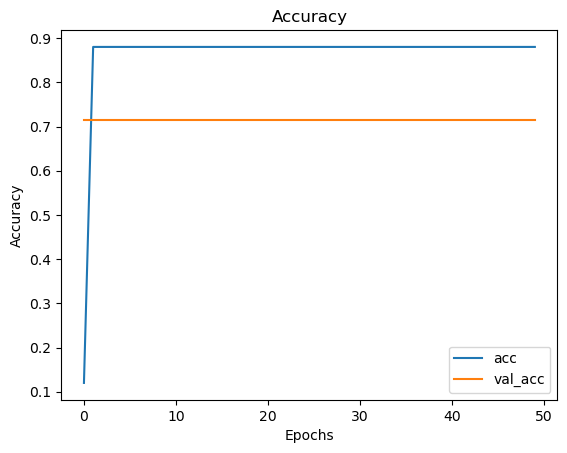

1/1 [==============================] - 4s 4s/step


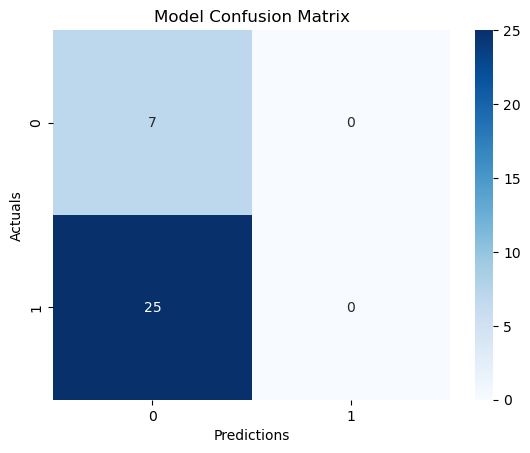

              precision    recall  f1-score   support

           0       0.22      1.00      0.36         7
           1       0.00      0.00      0.00        25

    accuracy                           0.22        32
   macro avg       0.11      0.50      0.18        32
weighted avg       0.05      0.22      0.08        32





/Users/jdapeman/anaconda3/envs/apple/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jdapeman/anaconda3/envs/apple/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jdapeman/anaconda3/envs/apple/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

1/1 [==============================] - 5s 5s/step - loss: 0.6245 - acc: 0.7812
Test Loss: 0.6245097517967224
Test Acc: 0.78125


In [105]:
test_result(results)


# Evaluation

- Surprisingly, 6 was a major improvement. However, the 7th iteration demonstrated a more balanced confusion matrix, with a closer balance between False Positives and False Negatives compared to previous iterations. The accuracy in 7 was also muh worse than previous models. 

Picking the best model:  
- When it comes to diagnosing pneumonia, the primary objective is to minimize the number of False Negatives. Why is that? It is preferable to erroneously classify someone as having pneumonia (False Positive) rather than misidentify an individual who is actually ill, leading to untreated condition (False Negative). However, having too many False Positives is also undesirable since it may result in unnecessary prescriptions of steroids or antibiotics for patients who do not require them. In this particular use-case, despite the model's predictions, the x-ray images will still be examined by human experts before reaching a final diagnosis. Consequently, it is crucial to have a highly accurate model overall to optimize the efficiency of the technician or doctor reviewing the x-rays. The greater the accuracy of the model, the less time they will need to spend in the review process.

Best Model

- Upon examining all the models, it is evident that model 6 achieves the highest accuracy, at 90%, and displays fewer instances of False Negatives compared to the majority of the other models.

Model selection: 

Due to this reason, I believe that model 6 is the most suitable for this specific use-case. It effectively mitigates False Negatives more effectively than any other model while also maintaining a low number of False Positives. Model 6 achieves an accuracy score of 90%, exhibiting the lowest count of both False Negatives and False Positives. 

1/1 [==============================] - 0s 117ms/step
True Class: 0.0
Predicted Class: 1


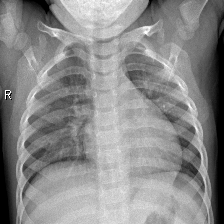

In [106]:
# Get random image and label
label = y_train[0]
img = X_train[0]

# Get model pred
pred = model_6.predict(np.array([img]))
pred_class = int(pred.round())

# Print true class, predicted class and image
print('True Class:', label)
print('Predicted Class:', pred_class)
array_to_img(img)

In [107]:
# Make an explainer
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(img, model_6.predict, top_labels=2,
                                         hide_color=None, num_samples=2000)

  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 135ms/step


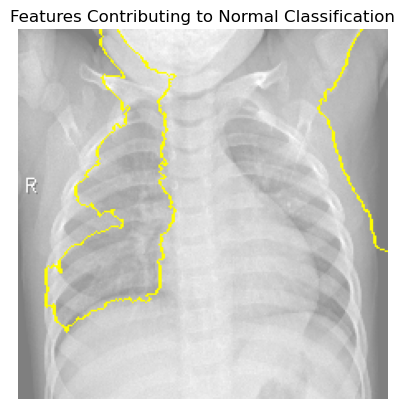

In [108]:
# Display features contributing to the pneumonia classification
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                            positive_only=True,
                                            num_features=5)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.axis('off')
plt.title('Features Contributing to Normal Classification')
plt.show()

1/1 [==============================] - 0s 34ms/step
True Class: 1.0
Predicted Class: 1


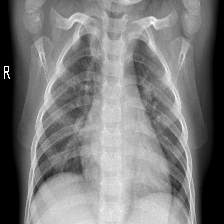

In [109]:
# Do the same with image at index 2
label2 = y_train[1]
img2 = X_train[1]

# Get model pred
pred2 = model_6.predict(np.array([img2]))
pred_class2 = int(pred.round())

# Print true class, predicted class and image
print('True Class:', label2)
print('Predicted Class:', pred_class2)
array_to_img(img2)

  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 142ms/step


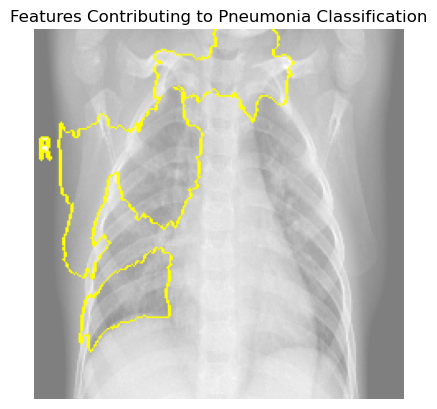

In [110]:
explanation2 = explainer.explain_instance(img2, model_6.predict, top_labels=2,
                                         hide_color=None, num_samples=2000)

temp2, mask2 = explanation2.get_image_and_mask(explanation.top_labels[0],
                                            positive_only=True,
                                            num_features=5)
plt.imshow(mark_boundaries(temp2 / 2 + 0.5, mask2))
plt.axis('off')
plt.title('Features Contributing to Pneumonia Classification')
plt.show()

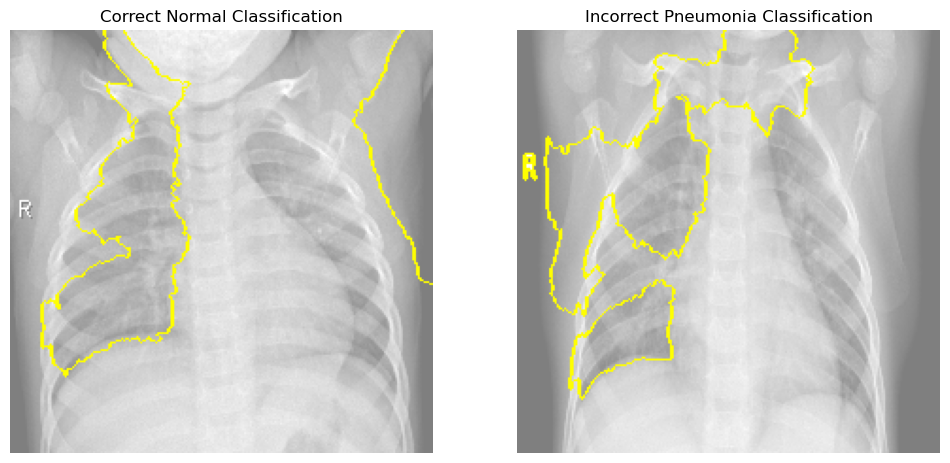

In [111]:
fig, axes = plt.subplots(1, 2, figsize=(12, 8))
axes[0].imshow(mark_boundaries(temp / 2 + 0.5, mask))
axes[1].imshow(mark_boundaries(temp2 / 2 + 0.5, mask2))
axes[0].axis('off')
axes[1].axis('off')
axes[0].set_title('Correct Normal Classification')
axes[1].set_title('Incorrect Pneumonia Classification')
plt.show()

Recommendations:
- Utilize this model as an efficient tool by implementing it in a radiology setting to assist x-ray technicians in pneumonia detection. For instance, upon capturing a chest x-ray, the model can automatically provide its prediction to the technician. This approach would minimize the time required for the technician and/or doctor to review the model's prediction, allowing them to rely on their expertise for a final diagnosis. Such implementation would enhance the overall efficiency of the department, enabling doctors and technicians to focus more on other tasks.

- To enhance the model's performance, it is suggested that x-ray technicians crop out the diaphragm from the image before inputting it into the model to reduce noise.

- Additionally, it is recommended that x-ray technicians save the images as 224x224 pixels before feeding them into the model.

Future Work:
- As there is considerable room for improvement with this model, potential future work could involve:

1. Retraining the model using smaller images, such as 64x64 pixels or 32x32 pixels.
2. Exploring additional preprocessing methods to remove the diaphragm and reduce noise.
3. Employing a freeze and unfreeze strategy for specific layers of transfer learning models to fine-tune their performance.
4. Conducting further research on alternative methods for tuning convolutional neural networks (CNNs) specifically for chest x-ray and pneumonia classification.